See, e.g., https://danvatterott.com/blog/2016/02/21/grouping-nba-players/ -- very helpful

In [2]:
import os, sys
sys.path.insert(0, '/Users/kv/workspace/kv-capstone/NBAwinshare/source')

from source import seasonalregressor, data_wrangle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error
%matplotlib inline

advanced = data_wrangle.read_all_advanced('./data/advanced')
pergame  = data_wrangle.read_all_pergame('./data/per_game')
seasonal = data_wrangle.clean_and_join_seasonal_dataframe(advanced, pergame)
demographic = data_wrangle.read_demographic_data('./data/player_data.csv')
fullstats = data_wrangle.add_years_in_league(seasonal, demographic)

cols_to_train_from_correlation = ['WS',
 'OWS',
 'VORP',
 'DWS',
 'MP_total',
 'PS/G',
 'FG',
 'MP_pergame',
 'GS',
 'FT',
 '2P',
 'FTA',
 'FGA',
 '2PA',
 'DRB']

with open('train_test.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    trainnames, testnames = pickle.load(f)
    
actuals = data_wrangle.get_actuals_for_years_5_thru_9(fullstats, testnames)

In [3]:
sr3 = seasonalregressor.SeasonalRegressor(columns_to_train=cols_to_train_from_correlation)
fulltrain, fulltest = sr3.create_train_test_split(fullstats, trainnames, testnames)

In [4]:
df, y, _ = sr3.create_train_and_predict_X_and_y_of_first_four_seasons(fullstats, 5)


Number of players:  578  with full season data for seasons: {1, 2, 3, 4, 5}
Indices of train set and to-predict set MATCH
Using all columns


In [5]:
df.head()

,Age,G,MP_total,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Price,24.5,51.75,876.50,12.150,0.48475,0.48700,0.20400,2.025,8.775,5.375,...,0.300,1.30,1.600,2.425,0.575,0.05,1.000,1.025,6.350,2.5
Aaron Gray,24.5,47.50,542.50,13.250,0.53850,0.00275,0.38050,14.025,22.325,18.125,...,1.350,2.15,3.550,0.650,0.300,0.30,0.750,2.075,3.550,2.5
Adonal Foyle,23.5,58.25,1095.25,11.550,0.44750,0.00150,0.30100,11.475,18.925,15.025,...,2.025,3.05,5.075,0.525,0.325,1.60,0.975,2.225,4.325,2.5
Adrian Griffin,26.5,62.00,1265.00,12.200,0.48575,0.15675,0.21525,6.975,15.350,11.075,...,1.200,2.50,3.675,1.575,1.075,0.15,0.750,2.150,5.100,2.5
Al Harrington,19.5,48.25,1054.75,10.425,0.47200,0.05925,0.31875,9.350,14.575,12.050,...,1.400,2.65,4.075,0.975,0.600,0.25,1.375,2.625,7.325,2.5


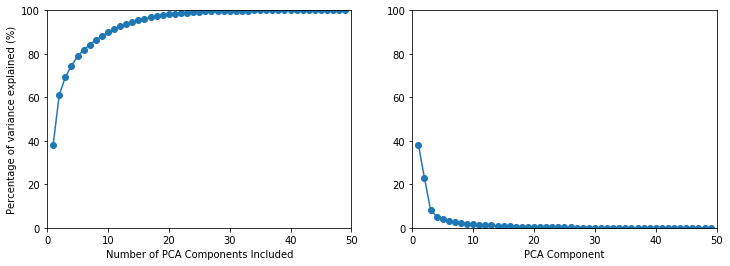

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.values #take data out of dataframe
X = scale(X) #standardize the data before giving it to the PCA.

pca = PCA()
pca.fit(X) #pull out principle components
var_expl = pca.explained_variance_ratio_ #find amount of variance explained by each component
tot_var_expl = np.array([sum(var_expl[0:i+1]) for i,x in enumerate(var_expl)]) #create vector with cumulative variance

plt.figure(figsize=(12,4)) #create cumulative proportion of variance plot
plt.subplot(1,2,1)
plt.plot(range(1,len(tot_var_expl)+1), tot_var_expl*100,'o-')
plt.axis([0, len(tot_var_expl)+1, 0, 100])
plt.xlabel('Number of PCA Components Included')
plt.ylabel('Percentage of variance explained (%)')

plt.subplot(1,2,2) 
plt.plot(range(1,len(var_expl)+1), var_expl*100,'o-')
plt.axis([0, len(var_expl)+1, 0, 100])
plt.xlabel('PCA Component');

Looks like we get 95% of the variance explained around the 14-15 mark

In [8]:
np.cumsum(var_expl)


array([0.38248429, 0.61065042, 0.69323413, 0.74518846, 0.78784129,
       0.81754989, 0.84260765, 0.86341314, 0.88216071, 0.8983799 ,
       0.9135191 , 0.92592926, 0.93775667, 0.94732717, 0.95546598,
       0.96157952, 0.96738599, 0.97273889, 0.97771355, 0.98175424,
       0.98518636, 0.98783599, 0.99003515, 0.99216329, 0.99379264,
       0.99522086, 0.99642775, 0.99711983, 0.99767457, 0.9981913 ,
       0.99861792, 0.99894057, 0.9992012 , 0.999397  , 0.99957497,
       0.99970624, 0.99979894, 0.99987785, 0.99993715, 0.99997297,
       0.99999046, 0.99999297, 0.99999479, 0.9999964 , 0.99999793,
       0.99999881, 0.99999955, 1.        , 1.        ])

Yep--using the first 14 PCAs will get us 94.7% of the variance explained

In [9]:
np.cumsum(var_expl)[13:15]

array([0.94732717, 0.95546598])

In [10]:
pd.DataFrame(pca.components_,columns=df.columns).head().T

,0,1,2,3,4
Age,-0.062581,-0.003926,-0.081212,0.110196,-0.049050
G,0.153883,-0.021284,-0.031020,0.038759,0.224353
MP_total,0.211988,-0.046669,0.042668,-0.002494,0.155993
PER,0.188668,0.072272,-0.098223,-0.002461,-0.213030
TS%,0.110295,0.072932,-0.372122,-0.016716,-0.176965
3PAr,-0.003510,-0.234766,-0.191744,-0.007095,0.217889
FTr,0.016589,0.152658,0.063754,0.065637,-0.327065
ORB%,-0.011892,0.275448,0.018064,-0.031727,-0.060485
DRB%,0.018787,0.263241,0.017182,-0.061786,0.080345
TRB%,0.005598,0.281886,0.016826,-0.048816,0.019755


<Figure size 432x288 with 0 Axes>

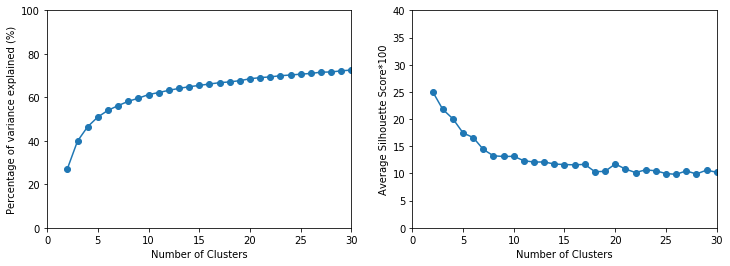

In [11]:
from scipy.spatial.distance import cdist, pdist, euclidean
from sklearn.cluster import KMeans
from sklearn import metrics


reduced_data = PCA(n_components=14).fit_transform(X) #transform data into the 14 PCA components space
#kmeans assumes clusters have equal variance, and whitening helps keep this assumption.

k_range = range(2,31) #looking amount of variance explained by 2 through 30 clusters
k_means_var = [KMeans(n_clusters=k).fit(reduced_data) for k in k_range] 

#get labels and calculate silhouette score
labels = [i.labels_ for i in k_means_var]
sil_score = [metrics.silhouette_score(reduced_data,i,metric='euclidean') for i in labels]

centroids = [i.cluster_centers_ for i in k_means_var] #get the center of each cluster
k_euclid = [cdist(reduced_data,cent,'euclidean') for cent in centroids] #calculate distance between each item and each cluster center
dist = [np.min(ke,axis=1) for ke in k_euclid] #get the distance between each item and its cluster

wcss = [sum(d**2) for d in dist] #within cluster sum of squares
tss = sum(pdist(reduced_data)**2/reduced_data.shape[0]) #total sum of squares
bss = tss-wcss #between cluster sum of squares

plt.clf()
plt.figure(figsize=(12,4)) #create cumulative proportion of variance plot
plt.subplot(1,2,1)
plt.plot(k_range, bss/tss*100,'o-')
plt.axis([0, np.max(k_range), 0, 100])
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of variance explained (%)');

plt.subplot(1,2,2) #create scree plot
plt.plot(k_range, np.transpose(sil_score)*100,'o-')
plt.axis([0, np.max(k_range), 0, 40])
plt.xlabel('Number of Clusters');
plt.ylabel('Average Silhouette Score*100');

In [12]:
final_fit = KMeans(n_clusters=10, random_state=42).fit(reduced_data)
df['kmeans_label'] = final_fit.labels_

In [14]:
df.groupby('kmeans_label').mean()['WS']

kmeans_label
0    2.234507
1    1.907500
2    7.309559
3    4.419776
4    0.996264
5    7.075000
6    4.330804
7    0.799375
8    2.791981
9    2.065672
Name: WS, dtype: float64

In [15]:
from collections import defaultdict
playergroups = {}
for i in range(10):
    playergroups[i] = set(df[df['kmeans_label']==i].index)

In [16]:
import pprint
pprint.pprint(playergroups)

{0: {'Alec Burks',
     'Allen Crabbe',
     'Alonzo Gee',
     'Anthony Morrow',
     'Anthony Tolliver',
     'Arron Afflalo',
     'Ben McLemore',
     'Brandon Rush',
     'Brian Cook',
     'Brian Roberts',
     'C.J. Watson',
     'Chase Budinger',
     'Courtney Lee',
     'Daequan Cook',
     'Damien Wilkins',
     'Daniel Gibson',
     'Danny Green',
     'Derrick Williams',
     'Evan Fournier',
     'Francisco Garcia',
     'Gary Neal',
     'Gordan Giricek',
     'Hedo Turkoglu',
     'Iman Shumpert',
     'Isaiah Canaan',
     'J.J. Redick',
     'J.R. Smith',
     'Jae Crowder',
     'Jamario Moon',
     'Jared Dudley',
     'Jarvis Hayes',
     'Jason Kapono',
     'Jeremy Lamb',
     'Jodie Meeks',
     'Jordan Farmar',
     'Keith Bogans',
     'Kent Bazemore',
     'Kyle Korver',
     'Kyle Singler',
     'Luther Head',
     'Marco Belinelli',
     'Marcus Morris',
     'Matt Bonner',
     'Matthew Dellavedova',
     'Maurice Harkless',
     'Mickael Pietrus',
     'M

<Figure size 432x288 with 0 Axes>

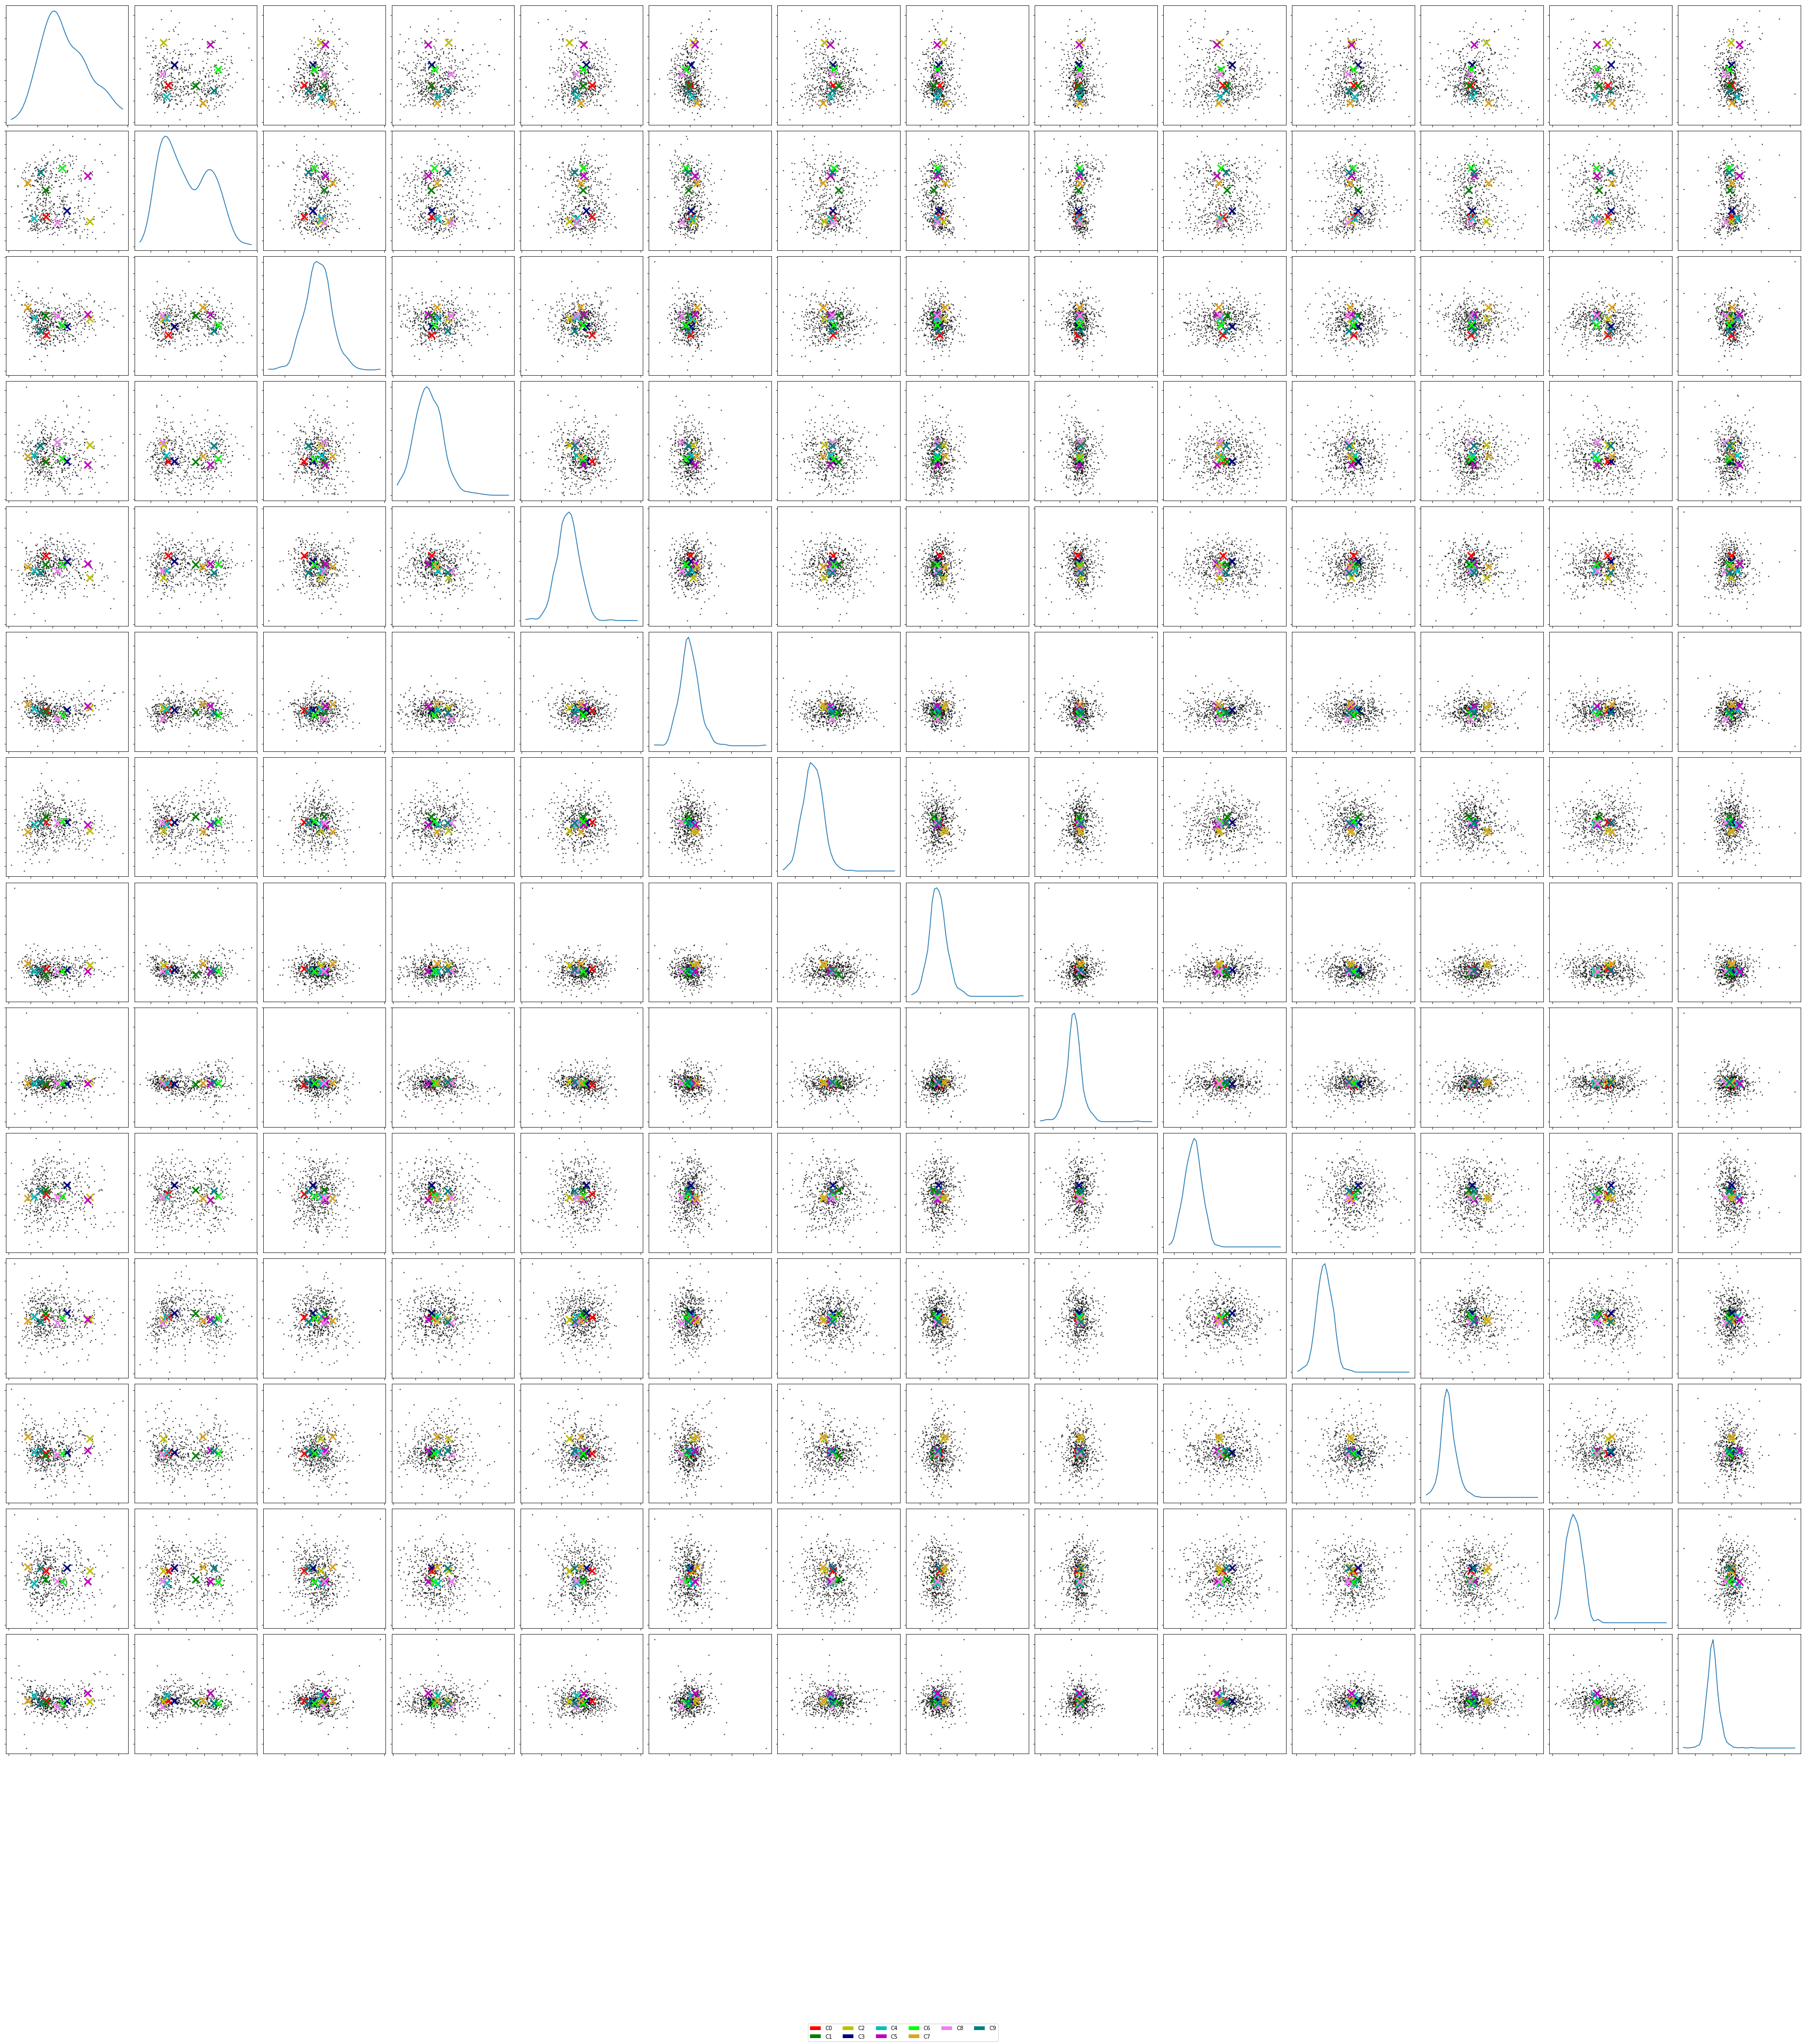

In [17]:
from scipy.stats import gaussian_kde
import matplotlib
plt.clf()

centroids = final_fit.cluster_centers_ #find centroids so we can plot them
colors = ['r','g','y','navy','c','m', 'lime','goldenrod','violet', 'teal'] #cluster colors
Clusters = ['C0','C1','C2','C3','C4','C5','C6', 'C7', 'C8', 'C9'] #cluster...names

numdata, numvars = reduced_data.shape #players by PCA components
fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(60,60)) 
fig.subplots_adjust(hspace=0.05, wspace=0.05)

recs=[]
for col in colors: #make some patches for the legend
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=col))

fig.legend(recs,Clusters,8,ncol=6) #create legend with patches above

for i,ax in enumerate(axes.flat):
    # Hide all ticks and labels
    plt.setp(ax.get_yticklabels(), visible=False) #tick labels are too much with this many subplots
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.grid(False) #again, too much
    #if i%5==0:ax.set_ylabel(factor_names[i/5]) #label outer y axes
    #if i>19:ax.set_xlabel(factor_names[i-20]) #label outer x axes

for i, j in zip(*np.triu_indices_from(axes, k=1)):
    for x, y in [(i,j), (j,i)]:
        #plot individual data points and cluster centers
        axes[y,x].plot(reduced_data[:, x], reduced_data[:, y], 'k.', markersize=2)
        axes[y,x].scatter(centroids[:,x], centroids[:,y],marker='x',s=169,linewidth=3,color=colors, zorder=10)

#create kernel density estimation for each PCA factor on the diagonals
for i in range(14):
    density = gaussian_kde(reduced_data[:,i])
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    x = np.linspace(min(reduced_data[:,i]),max(reduced_data[:,1]))
    axes[i,i].plot(x,density(x))

In [18]:
for i in range(10):
    print('i: ',i)
    print(df.iloc[np.argmin([euclidean(x,final_fit.cluster_centers_[i]) for x in reduced_data])])

i:  0
Age                 22.50000
G                   58.25000
MP_total          1258.00000
PER                 13.95000
TS%                  0.53775
3PAr                 0.43700
FTr                  0.18325
ORB%                 3.22500
DRB%                14.70000
TRB%                 8.85000
AST%                 9.70000
STL%                 1.25000
BLK%                 0.67500
TOV%                 8.92500
USG%                19.82500
OWS                  1.60000
DWS                  0.95000
WS                   2.55000
WSp48                0.09300
OBPM                 0.35000
DBPM                -1.30000
BPM                 -0.90000
VORP                 0.37500
Season            2011.50000
GS                   9.00000
MP_pergame          21.72500
FG                   3.50000
FGA                  8.10000
FG%                  0.43050
3P                   1.22500
3PA                  3.55000
3P%                  0.35425
2P                   2.22500
2PA                  4.57500
2P%     

In [19]:
def make_dendrogram(dataframe, linkage_method, metric, color_threshold=None, fontsize=12., savefile=None):
    '''
    This function creates and plots the dendrogram created by hierarchical clustering.
    
    INPUTS: Pandas Dataframe, string, string, int, fontsize (float), savefile (string)
    
    OUTPUTS: None
    '''
    distxy = squareform(pdist(dataframe.values, metric=metric))
    Z = linkage(distxy, linkage_method)
    plt.figure(figsize=(54, 20))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Players')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=fontsize,  # font size for the x axis labels
        labels = dataframe.index,
        color_threshold = color_threshold
    )
    if savefile:
        plt.savefig(savefile,bbox_inches='tight',dpi=1000)
    plt.show()

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


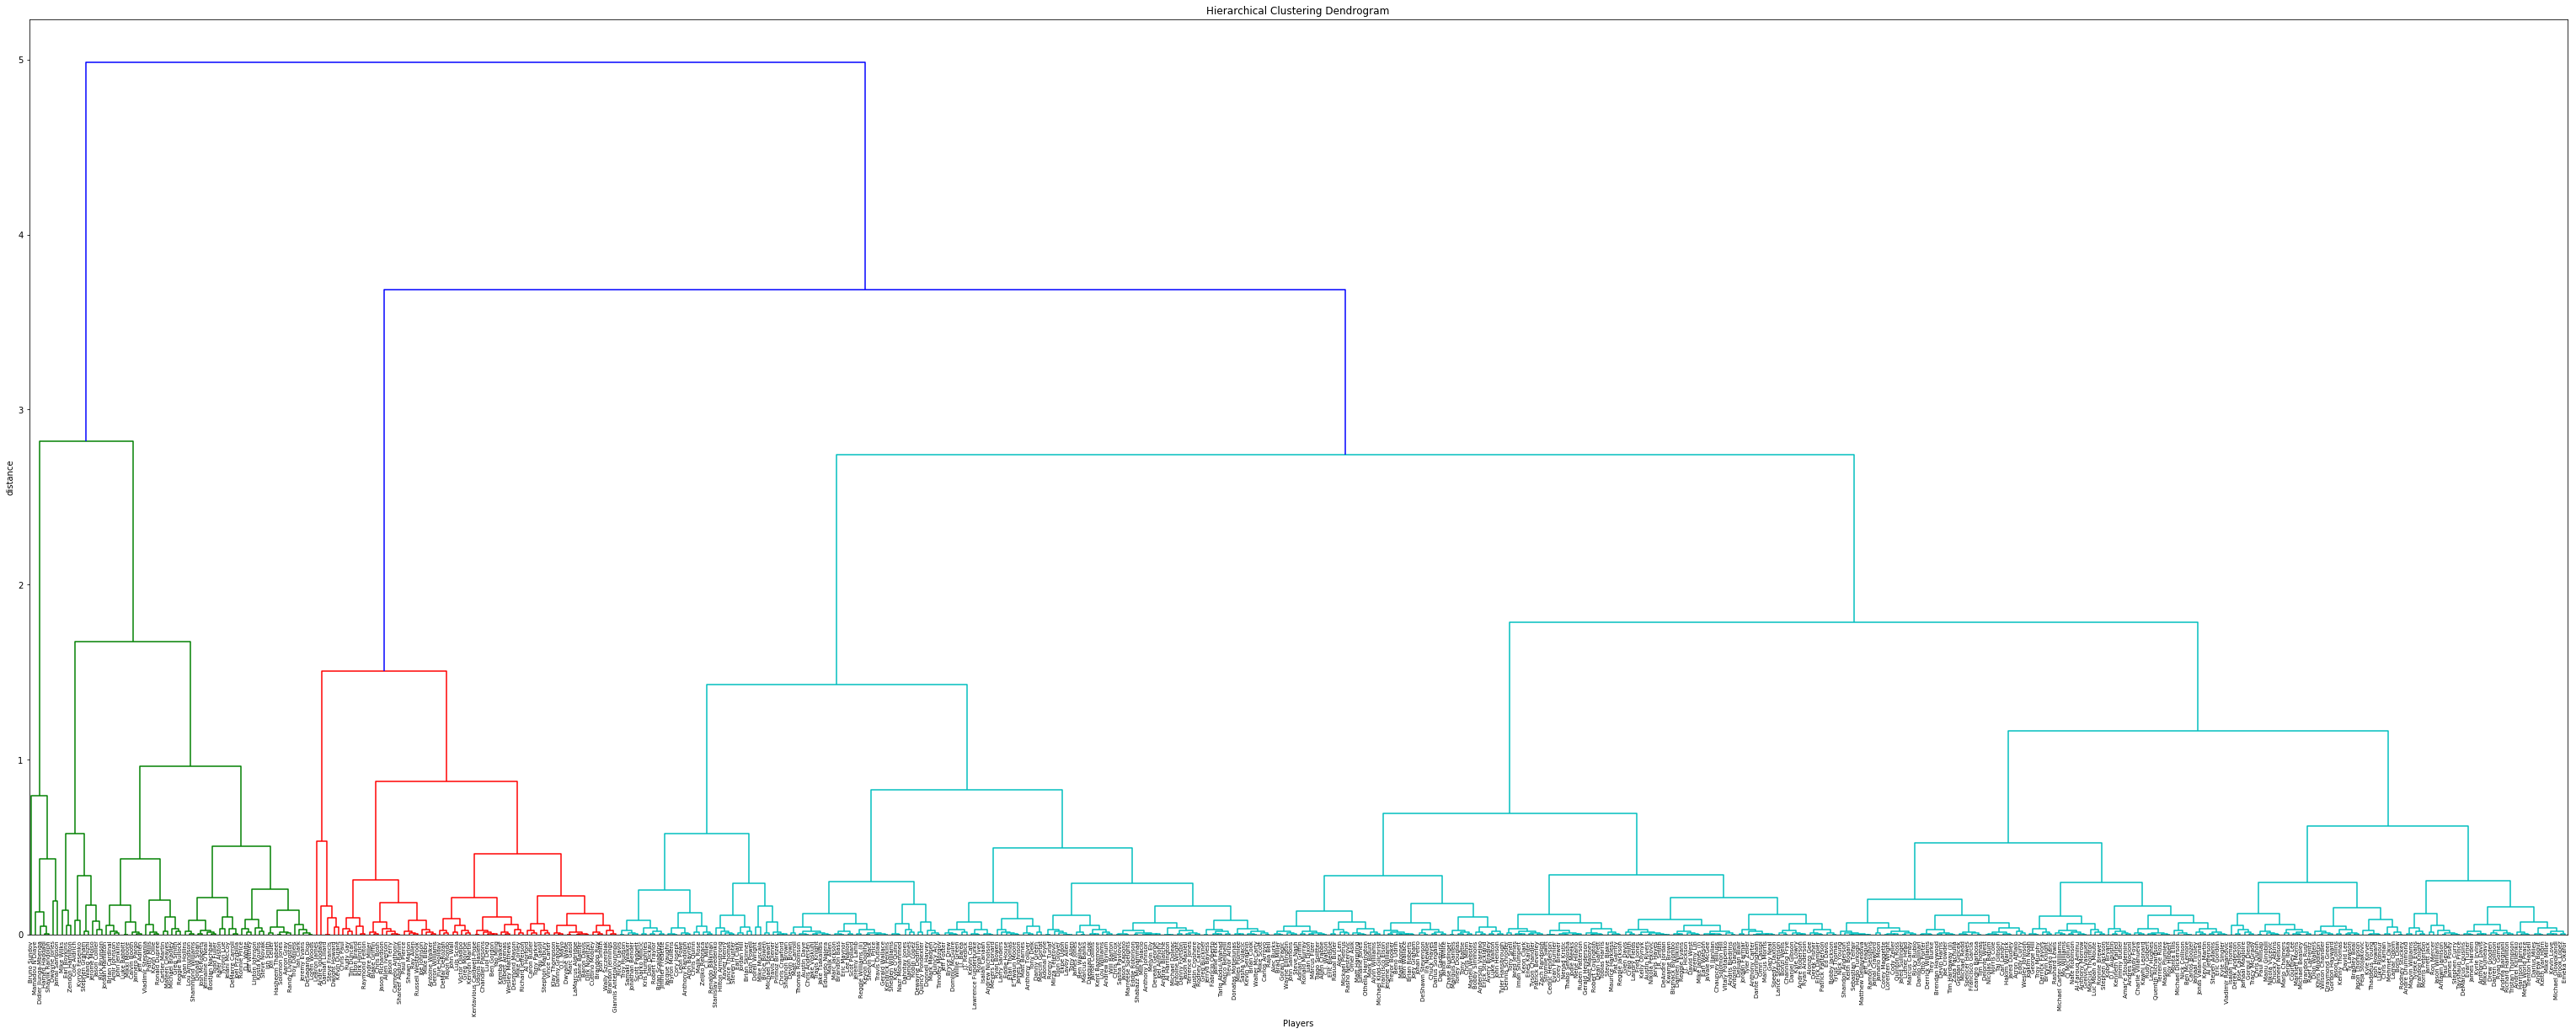

In [21]:
linktype = 'complete'
metric = 'cosine'
make_dendrogram(df.iloc[:,:-2], linktype, metric, color_threshold=None, fontsize=7)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


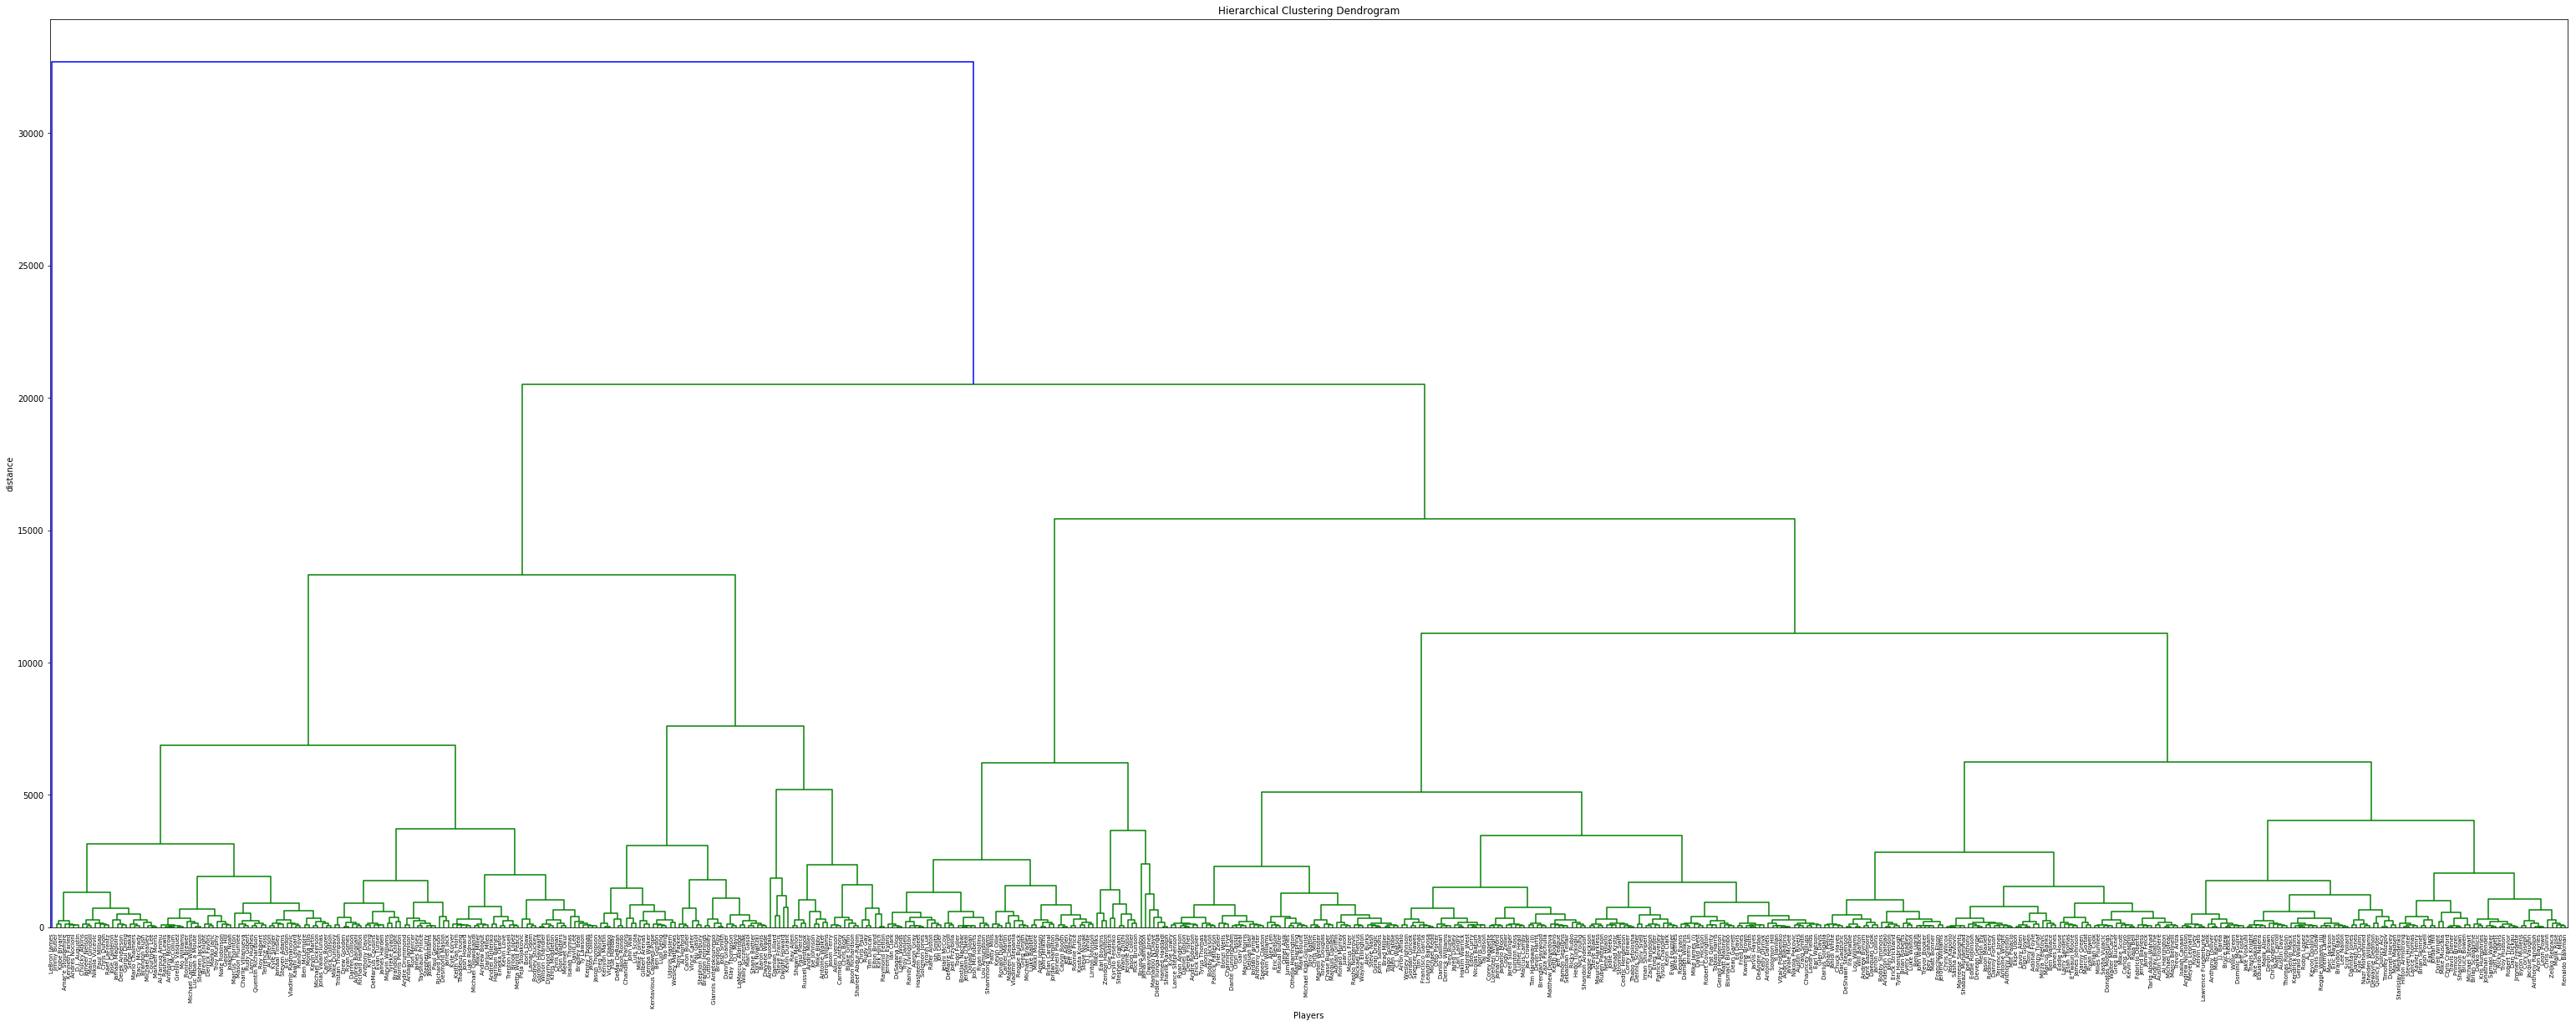

In [23]:
linktype = 'average'
metric = 'euclid'
make_dendrogram(df.iloc[:,:-2], linktype, metric, color_threshold=None, fontsize=7)

In [ ]:
make_dendrogram(df.iloc[:,:-2], linktype, metric, color_threshold=None, fontsize=7, savefile='LBJ_dendrogram.png')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.
